In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os


BASE_DIR = "/kaggle/input/flickr8k"

WORKING_DIR = os.getcwd()

print("Working Directory:", WORKING_DIR)
print("Base Directory:", BASE_DIR)

Working Directory: /kaggle/working
Base Directory: /kaggle/input/flickr8k


In [ ]:
pip install tensorflow==1.14

In [5]:


tf.executing_eagerly()


True

In [2]:
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Embedding, LSTM, Dropout, Flatten, Input, add
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical, plot_model

2024-04-14 22:40:45.398341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 22:40:45.398432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 22:40:45.523045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd

captions_df = pd.read_csv(os.path.join(BASE_DIR, 'captions.txt'))

captions_df.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [4]:
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import shutil

# Specify the source folder path from the dataset
src_folder = '/kaggle/input/flickr8k'

# Specify the destination folder path in your working directory
dst_folder = WORKING_DIR + "/flickr8k"

# Copy the folder and its contents to the working directory
shutil.copytree(src_folder, dst_folder)

In [5]:
dir = WORKING_DIR + '/flickr8k/Images'

img_paths = []

for img_name in os.listdir(dir):
    img_path = dir + '/' + img_name
    img_paths.append(img_path)
    
print(len(img_paths))
print(img_paths[0])

8091
/kaggle/working/flickr8k/Images/1515025681_999199cb79.jpg


In [6]:
from keras.applications.vgg16 import preprocess_input

In [7]:
def load_image(image_path):
    image_path_str = tf.strings.as_string(image_path)  # Convert tensor to string tensor
    image_name = tf.strings.split(tf.strings.split(image_path_str, '/')[-1], '.')[0]  # Extract image name
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_name

In [8]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")


Let's check the BatchDataset shapes--> <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [14]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
# %%time
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
import shutil

save_dir = 'kaggle/working/Features'

#shutil.rmtree('/kaggle/working/flickr8k')

In [ ]:
 os.makedirs('Features', exist_ok = True)

In [ ]:
os.remove('/kaggle/working/Features/Tensor("args_0:0", shape=(), dtype=string).pkl')

In [ ]:
shutil.rmtree('/kaggle/working/kaggle')

In [ ]:
# for item in image_dataset.take(1):
#     print(item)

In [ ]:
import pickle

save_dir = tf.constant(WORKING_DIR + '/Features')
save_dir = save_dir.numpy().decode('utf-8')

for img, name in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, image_name in zip(batch_features, name):
    image_feature_name = image_name.numpy().decode('utf-8')
    #image_feature_name = p.numpy().decode('utf-8')
    #full_path = os.path.join(save_dir, image_feature_name)
    #print(save_dir)
    #print(image_feature_name)
   
    with open(os.path.join(save_dir, image_feature_name + '.pkl'),'wb') as f:
        pickle.dump(bf,f)
        

In [7]:
count = 0

save_dir = '/kaggle/working/Features'

for i in os.listdir(save_dir):
    count += 1
    
print(count)

8091


In [ ]:
tf.data.Dataset.from_tensor_slices?

In [ ]:
bf.numpy().shape

In [ ]:
print(batch_features.numpy().shape)

In [ ]:
len(captions_df.caption)

In [ ]:
len(set(captions_df.image))

In [9]:
def get_name(path):
    name = os.path.basename(path)
    name = name.split('.')[0]
    return name

name = get_name('/kaggle/working/flickr8k/Images/2567035103_3511020c8f.jpg')
print(name)

2567035103_3511020c8f


In [10]:
all_captions = []

for caption in captions_df['caption']:
    caption = "<SOS> " + caption + " <EOS>"
    all_captions.append(caption)
    
all_captions[:10]

['<SOS> A child in a pink dress is climbing up a set of stairs in an entry way . <EOS>',
 '<SOS> A girl going into a wooden building . <EOS>',
 '<SOS> A little girl climbing into a wooden playhouse . <EOS>',
 '<SOS> A little girl climbing the stairs to her playhouse . <EOS>',
 '<SOS> A little girl in a pink dress going into a wooden cabin . <EOS>',
 '<SOS> A black dog and a spotted dog are fighting <EOS>',
 '<SOS> A black dog and a tri-colored dog playing with each other on the road . <EOS>',
 '<SOS> A black dog and a white dog with brown spots are staring at each other in the street . <EOS>',
 '<SOS> Two dogs of different breeds looking at each other on the road . <EOS>',
 '<SOS> Two dogs on pavement moving toward each other . <EOS>']

In [11]:
image_names = []

for name in captions_df['image']:
    image_name = get_name(name)
    image_names.append(image_name)
    
image_names[:10]

['1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70']

In [12]:
from sklearn.utils import shuffle

shuffled_captions, shuffled_image_names = shuffle(all_captions,
                                                  image_names,
                                                  random_state=1)

In [ ]:
#len(shuffled_captions)


In [ ]:
# len(shuffled_image_names)
# shuffled_image_names[:10]

In [13]:
#function for getting maxlen of the caption

def get_maxlen(captions):
    len_caption = []
    for caption in captions_df['caption']:
        len_caption.append(len(caption.split()))

    return max(len_caption)

In [14]:
# utilizing the tokenizer 

tokenizer = Tokenizer(oov_token = '<unk>', filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(shuffled_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(shuffled_captions)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


8498


In [18]:
tokenizer.word_index['<sos>']

3

In [15]:
max_length = get_maxlen(train_seqs)
print(max_length)


38


In [16]:
caption_vector = pad_sequences(train_seqs, maxlen = max_length, padding = 'post')
print(caption_vector.shape)

(40455, 38)


In [17]:
# train test split

from sklearn.model_selection import train_test_split

train_image, test_image, train_caption, test_caption = train_test_split(shuffled_image_names,
                                                                        caption_vector,
                                                                       test_size = 0.2,
                                                                       random_state = 0)

In [22]:
len(train_image), len(test_image), len(train_caption), len(test_caption)

(32364, 8091, 32364, 8091)

In [16]:
train_image[0]

'386655611_1329495f97'

In [17]:
train_caption[0]

array([  3,   6,  28,   9,  15,  10, 354,   2, 297,  56, 128, 125,   6,
        43,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(train_image) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49


In [19]:

save_dir = tf.constant(WORKING_DIR + '/Features')
save_dir = save_dir.numpy().decode('utf-8')

def map_func(image_name, caption):
    name = tf.constant(image_name)
    image_name_str = name.numpy().decode('utf-8')
    with open(os.path.join(str(save_dir), image_name_str + ".pkl"),'rb') as f:
        img_tensor = pickle.load(f)
    return img_tensor, caption

tensor, cap = map_func(train_image[0], train_caption[0])
print(tensor)
print(cap)


tf.Tensor(
[[1.9511101  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.01533079 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]], shape=(49, 512), dtype=float32)
[  3   6  28   9  15  10 354   2 297  56 128 125   6  43   4   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
# for i in os.listdir(features_dir):
#     name = i.split('.')[0]
#     if name == train_image[0]:
#         print("found")
#         break
#     else:
#         continue
        


In [20]:

dataset = tf.data.Dataset.from_tensor_slices((train_image, train_caption))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
for item in dataset.take(1):
    print(item)

In [ ]:
len(dataset)

In [ ]:
tf.data.experimental.enable_debug_mode()

# Model


In [21]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state, c_state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [22]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# num_steps = len(train_image) // BATCH_SIZE
# features_shape = 512
# attention_features_shape = 49

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [30]:
# saving checkpoint

checkpoint_path_ckpt = WORKING_DIR + "/checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [31]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

# Training

In [33]:
import time

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.9225
Epoch 1 Batch 100 Loss 1.6593
Epoch 1 Batch 200 Loss 1.3734
Epoch 1 Batch 300 Loss 1.2499
Epoch 1 Batch 400 Loss 1.3430
Epoch 1 Batch 500 Loss 1.1350
Epoch 1 Loss 1.414655
Time taken for 1 epoch 159.21123886108398 sec

Epoch 2 Batch 0 Loss 1.1109
Epoch 2 Batch 100 Loss 1.1521
Epoch 2 Batch 200 Loss 1.0571
Epoch 2 Batch 300 Loss 1.1522
Epoch 2 Batch 400 Loss 0.9843
Epoch 2 Batch 500 Loss 1.0116
Epoch 2 Loss 1.079200
Time taken for 1 epoch 109.31047177314758 sec

Epoch 3 Batch 0 Loss 0.9068
Epoch 3 Batch 100 Loss 1.0015
Epoch 3 Batch 200 Loss 0.9048
Epoch 3 Batch 300 Loss 1.0795
Epoch 3 Batch 400 Loss 0.9504
Epoch 3 Batch 500 Loss 0.8798
Epoch 3 Loss 0.965450
Time taken for 1 epoch 109.3357286453247 sec

Epoch 4 Batch 0 Loss 1.0753
Epoch 4 Batch 100 Loss 0.8913
Epoch 4 Batch 200 Loss 0.9309
Epoch 4 Batch 300 Loss 0.8761
Epoch 4 Batch 400 Loss 0.9023
Epoch 4 Batch 500 Loss 0.7779
Epoch 4 Loss 0.886709
Time taken for 1 epoch 109.17050623893738 sec

Epoch 5 Batch

In [30]:
start_epoch = 20

In [32]:
import time

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_losss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 21 Batch 0 Loss 0.3647
Epoch 21 Batch 100 Loss 0.3851
Epoch 21 Batch 200 Loss 0.3812
Epoch 21 Batch 300 Loss 0.4094
Epoch 21 Batch 400 Loss 0.4313
Epoch 21 Batch 500 Loss 0.3612
Epoch 21 Loss 0.390014
Time taken for 1 epoch 141.63720679283142 sec

Epoch 22 Batch 0 Loss 0.4246
Epoch 22 Batch 100 Loss 0.3578
Epoch 22 Batch 200 Loss 0.3745
Epoch 22 Batch 300 Loss 0.4171
Epoch 22 Batch 400 Loss 0.3316
Epoch 22 Batch 500 Loss 0.3638
Epoch 22 Loss 0.380355
Time taken for 1 epoch 110.64149045944214 sec

Epoch 23 Batch 0 Loss 0.3756
Epoch 23 Batch 100 Loss 0.3528
Epoch 23 Batch 200 Loss 0.3243
Epoch 23 Batch 300 Loss 0.3477
Epoch 23 Batch 400 Loss 0.3792
Epoch 23 Batch 500 Loss 0.3625
Epoch 23 Loss 0.371059
Time taken for 1 epoch 110.5745267868042 sec

Epoch 24 Batch 0 Loss 0.4134
Epoch 24 Batch 100 Loss 0.3364
Epoch 24 Batch 200 Loss 0.3418
Epoch 24 Batch 300 Loss 0.3194
Epoch 24 Batch 400 Loss 0.3660
Epoch 24 Batch 500 Loss 0.3642
Epoch 24 Loss 0.362084
Time taken for 1 epoch 110.60355

In [33]:
ckpt_manager.save()

'/kaggle/working/checkpoint_final/train/ckpt-15'

In [60]:
checkpoint_path_ckpt = WORKING_DIR + "/checkpoint_final/train"

checkpoint_path = checkpoint_path_ckpt
#tf.compat.v2.keras.callbacks.ModelCheckpoint
ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    # Restore the latest checkpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)


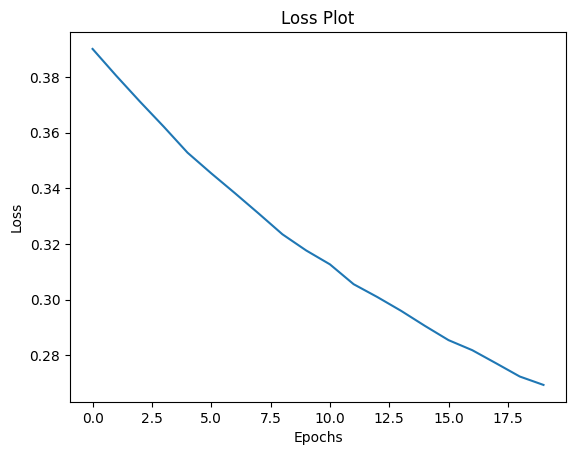

In [34]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [35]:
with open(WORKING_DIR + "/loss_plot", 'wb') as f:
    pickle.dump(loss_plot, f)

In [31]:
with open(WORKING_DIR + "/loss_plot", "rb") as f:
    loss_plot = pickle.load(f)

In [38]:
import json
from glob import glob
from PIL import Image

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

#     img_path = tf.constant(BASE_DIR + '/Images/' + image)
#     print(img_path)
#     img = load_image(img_path)[0]

#     temp_input = tf.expand_dims(img, 0)
#     img_tensor_val = image_features_extract_model(temp_input)

    name = image.split('.')[0]

    with open(WORKING_DIR + '/Features/' + name + ".pkl","rb") as t:
        img_tensor_val = pickle.load(t)
        
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<eos>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [39]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(os.path.join(WORKING_DIR, 'flickr8k/Images',image)))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    #plt.tight_layout()
    plt.show()

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_caption(image):
  real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  for i in result:
      if i=="<unk>":
          result.remove(i)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)
  # opening the image
  #Image.open(os.path.join(WORKING_DIR, 'Images', image + ".jpg"))
  path = os.path.join(WORKING_DIR, 'flickr8k/Images', image)
  img = mpimg.imread(path)
  plt.imshow(img)


tf.Tensor(b'/kaggle/working/flickr8k/Images/1465666502_de289b3b9c.jpg', shape=(), dtype=string)
Real Caption: <sos> a black dog wearing a red collar is dragging a rope though a river <eos>
Prediction Caption: a black dog swimming through water <eos>


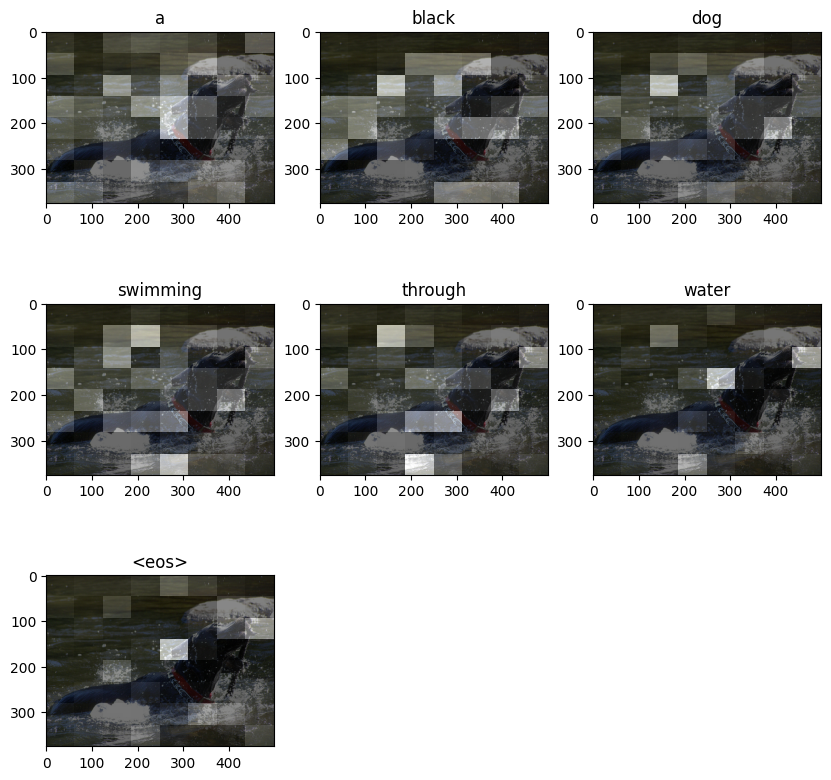

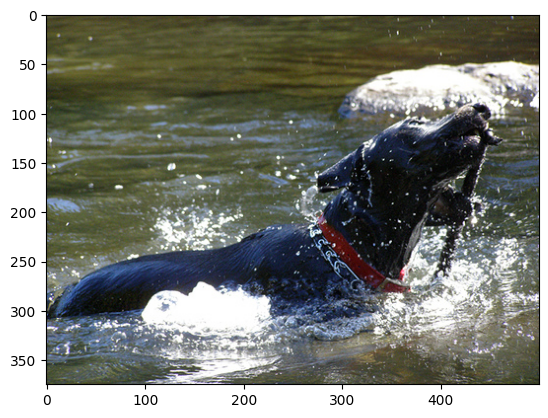

In [53]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

tf.Tensor(b'/kaggle/working/flickr8k/Images/2698614194_b4e6e11dff.jpg', shape=(), dtype=string)
Real Caption: <sos> the player wearing the black and white jersey jumps for the ball amidst two players from the other team as his two teammates run to help him <eos>
Prediction Caption: a group of men play football <eos>


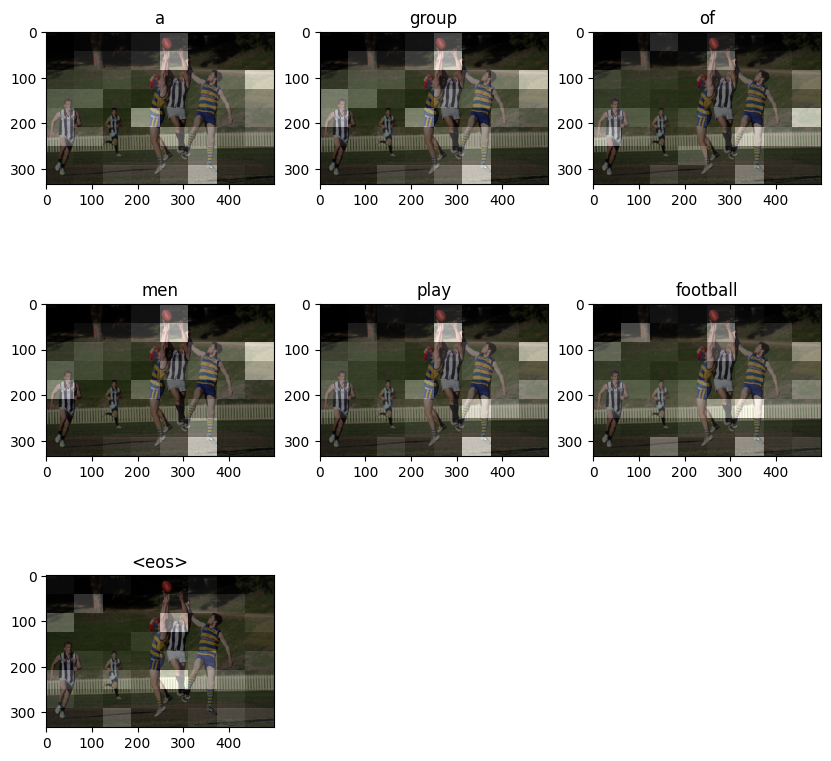

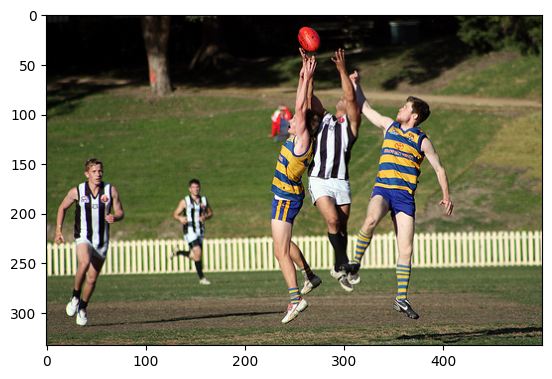

In [59]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

Real Caption: <sos> little girl with knit cap smelling flowers <eos>
Prediction Caption: a little girl smelling a white flowers <eos>


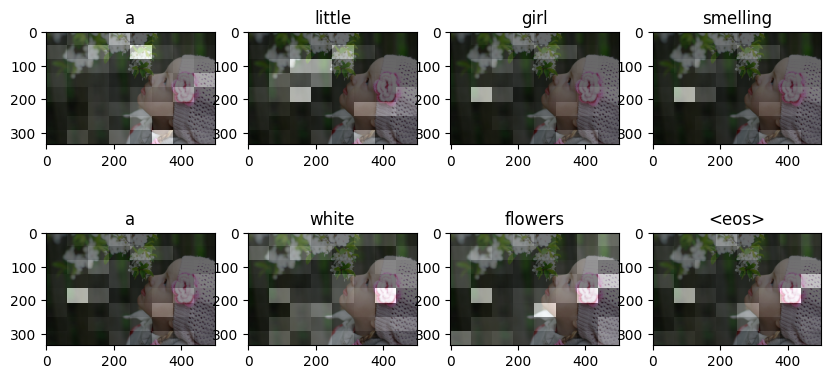

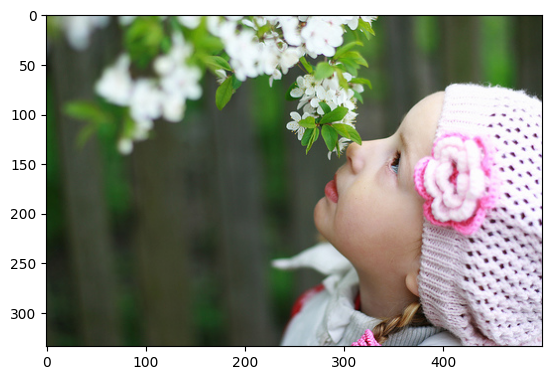

In [46]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

tf.Tensor(b'/kaggle/working/flickr8k/Images/3672106148_56cfb5fc8d.jpg', shape=(), dtype=string)


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 0.15249857033260467
Real Caption: the man is laying in the field reading a book
Prediction Caption: a man lays on a grassy field reading a book


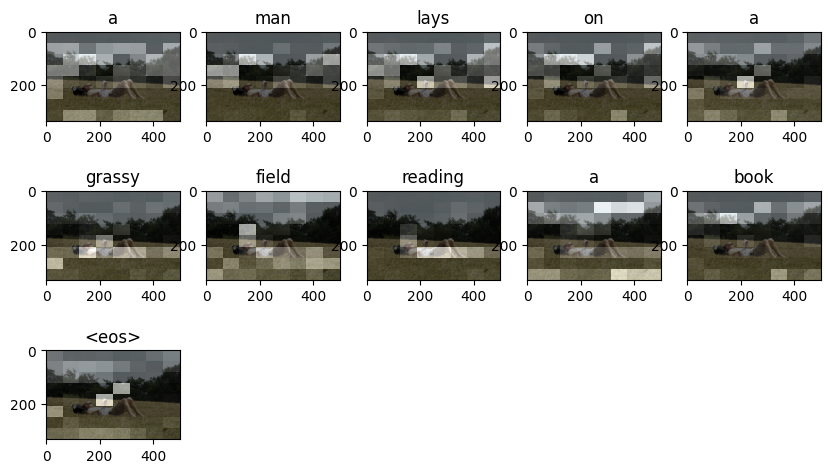

time took to Predict: 2 sec


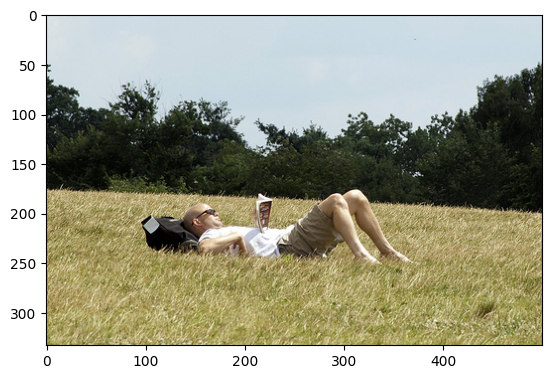

In [56]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'flickr8k/Images', image)
img = mpimg.imread(path)
plt.imshow(img)

tf.Tensor(b'/kaggle/working/flickr8k/Images/3662909101_21b9e59a3e.jpg', shape=(), dtype=string)
BLEU score: 0.254000254000381
Real Caption: a black dog jumps over a show jumping hurdle
Prediction Caption: a black dog jumps over a hurdle


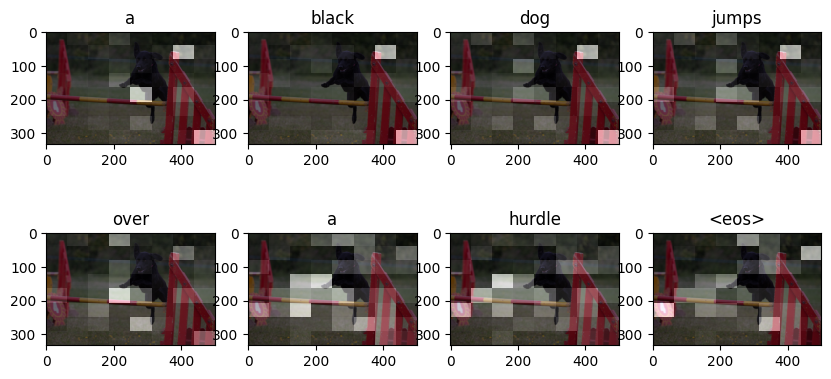

time took to Predict: 2 sec


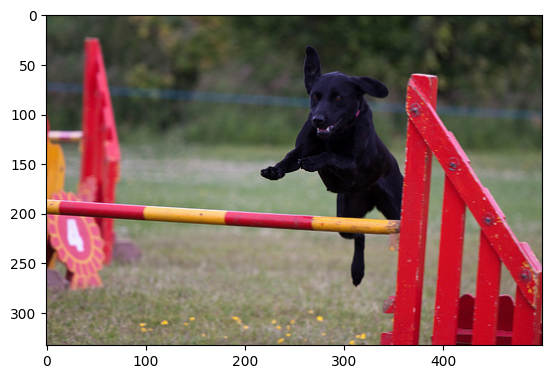

In [58]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'flickr8k/Images', image)
img = mpimg.imread(path)
plt.imshow(img)

In [1]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [7]:
# import zipfile
# import os
# from IPython.display import FileLink

# def zip_dir(directory = os.path.join(WORKING_DIR), file_name = 'Features.zip'):
#     """
#     zip all the files in a directory
    
#     Parameters
#     _____
#     directory: str
#         directory needs to be zipped, defualt is current working directory
        
#     file_name: str
#         the name of the zipped file (including .zip), default is 'directory.zip'
        
#     Returns
#     _____
#     Creates a hyperlink, which can be used to download the zip file)
#     """
#     os.chdir(directory)
#     zip_ref = zipfile.ZipFile(file_name, mode='w')
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             if file_name in file:
#                 pass
#             else:
#                 zip_ref.write(os.path.join(folder, file))

#     return FileLink(file_name)


In [1]:
#!zip -r file.zip /kaggle/working/Features

In [25]:
# reading captions
import os 

with open(os.path.join(BASE_DIR,"captions.txt"),"r") as c:
  next(c)
  read_captions = c.read() # reading the file 'captions.txt' into read_captions

In [40]:
# creating mapping of image to their captions

from tqdm.notebook import tqdm

def create_mapping(doc):
  mapping = {}

  for line in tqdm(doc.split("\n")):
    if len(line) < 2:
      continue
    words = line.split(",")
    img_name = words[0]
    image_id = img_name.split(".")[0]

    caption = words[1:]
    caption = " ".join(caption)

    if image_id not in mapping:
      mapping[image_id] = []

    mapping[image_id].append(caption)

  return mapping

mapping = create_mapping(read_captions)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [59]:
from sklearn.model_selection import train_test_split

image_ids = list(mapping.keys())

train, test = train_test_split(image_ids, test_size = 0.2, random_state = 42)

In [45]:
len(test)

1619

In [41]:
import pickle

with open(os.path.join(WORKING_DIR,'mapping.pkl'),'wb') as f:
    pickle.dump(mapping, f)

In [47]:
import pickle

with open(os.path.join(WORKING_DIR,'mapping.pkl'),'rb') as r:
    mapping = pickle.load(r)

In [48]:
mapping['3662909101_21b9e59a3e']

['A black dog jumping over a hurdle .',
 'A black dog jumps in the air over the red hurdle .',
 'A black dog jumps over an obstacle .',
 'A black dog jumps over a show jumping hurdle .',
 'a black dog running a course at a dog show']

In [49]:

def preprocess(mapping):
  for id,captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      
      temp = []
      for word in caption.split():
        if len(word) > 1:
          temp.append(word)
      caption = "<SOS> " + ' '.join(temp) + " <EOS>"
      captions[i] = caption

preprocess(mapping)


In [50]:
mapping['3662909101_21b9e59a3e']

['<SOS> black dog jumping over hurdle <EOS>',
 '<SOS> black dog jumps in the air over the red hurdle <EOS>',
 '<SOS> black dog jumps over an obstacle <EOS>',
 '<SOS> black dog jumps over show jumping hurdle <EOS>',
 '<SOS> black dog running course at dog show <EOS>']

In [71]:


def predict_caption_for_test(image_name):
    hidden = decoder.reset_state(batch_size=1) 
    
    img_features_path = WORKING_DIR + '/Features/' + image_name + '.pkl'
    
    with open(img_features_path, 'rb') as f:
        img_tensor_val = pickle.load(f)
        
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) 
    
    features = encoder(img_tensor_val)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<eos>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<eos>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [97]:
actual, predicted = list(), list()

In [61]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    #print(captions)
    
    key = key + ".jpg"
    result, _ = evaluate(key)
    
    for i in result:
      if i=="<unk>":
          result.remove(i)
    
    actual_captions = []
    
        
    for caption in captions:
        cap = list()
        words = caption.split()
        
        for word in words:
            if word in ['<SOS>','<EOS>']:
                continue
            cap.append(word)
        actual_captions.append(cap)
    
    actual.append(actual_captions)
    predicted.append(result)
    
#     print(actual)
#     print(predicted)
   

print("Bleu Score for Image Captioning(Inceptionv3)")

smoothing_function = SmoothingFunction()

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function = smoothing_function.method1))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function = smoothing_function.method1))
    
    

  0%|          | 0/1619 [00:00<?, ?it/s]

Bleu Score for Image Captioning(Inceptionv3)
BLEU-1: 0.424867
BLEU-2: 0.339138


In [42]:
with open(WORKING_DIR + '/actual.pkl','wb') as a:
    pickle.dump(actual, a)
    
with open(WORKING_DIR + '/predicted.pkl','wb') as p:
    pickle.dump(predicted, p)

In [100]:
print("Bleu Score for Image Captioning(VGG16)")

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

Bleu Score for Image Captioning(VGG16)
BLEU-1: 0.426422
BLEU-2: 0.328011
